In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found e

In [3]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [4]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)  # 从均值为0，方差为0.01的正态分布中抽取随机数，初始化权重
        self.b = torch.zeros(1, requires_grad=True)  # 初始化bias

$\mathbf{Xw} + b$

In [5]:
# model
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

In [6]:
# loss function
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

In [7]:
# 优化算法，采用小批量随机梯度下降算法
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [8]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [9]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()  # train
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()  # evaluate
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

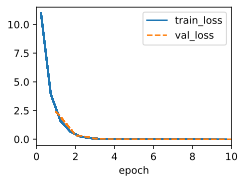

In [10]:
model = LinearRegressionScratch(num_inputs=2, lr=0.03)  # input_nums，学习率
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)  # 合成数据
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [11]:
# 与真实的w和b比较
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([-0.0005, -0.0002])
error in estimating b: tensor([0.0003])
